<a href="https://colab.research.google.com/github/DavinciB/child_grooming_detector/blob/main/PredatorComparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
import xml.etree.ElementTree as ET
import csv
def get_susp_conv_dict(data_path):
    labels_dict = {}
    with open(data_path + 'sci_labels.csv', 'r') as f:
        file = csv.reader(f)
        for row in file:
            labels_dict[row[0]] = row[1]
    return labels_dict

def get_predators_dict(file): 
    all_predators = {}
    with open(file, 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            all_predators[row[0]] = 1
    return all_predators
            

def get_features_labels(root, labels_dict, all_predators):
    corpus = []
    labels = []
    for conversation in root:
        if labels_dict[conversation.get('id')] == '0':
            continue
        author_conv_dict = {}
        for message in conversation:
            author = message.find('author').text
            text = message.find('text').text
            if text is not None:
                if author not in author_conv_dict:
                    author_conv_dict[author] = text
                else:
                    author_conv_dict[author] += " " + text 
        for author, conv in author_conv_dict.items():
            corpus.append(conv)
            if author in all_predators:
                labels.append(1)
            else:
                labels.append(-1)
    return corpus, labels

In [19]:
train_data_path = '/content/drive/MyDrive/online-grooming-detector-master/data/svm_training_data/'
training_xml = ET.parse(train_data_path + 'training_data.xml')
train_root = training_xml.getroot()

test_data_path = '/content/drive/MyDrive/online-grooming-detector-master/data/svm_test_data/'
test_data_src = '/content/drive/MyDrive/online-grooming-detector-master/data/pan12-sexual-predator-identification-test-corpus-2012-05-21/'
test_xml = ET.parse(test_data_src + 'pan12-sexual-predator-identification-test-corpus-2012-05-17.xml')
test_root = test_xml.getroot()

pred_train_file_path = '/content/drive/MyDrive/online-grooming-detector-master/data/pan12-sexual-predator-identification-training-corpus-2012-05-01/pan12-sexual-predator-identification-training-corpus-predators-2012-05-01.txt'
pred_test_file_path = '/content/drive/MyDrive/online-grooming-detector-master/data/pan12-sexual-predator-identification-test-corpus-2012-05-21/pan12-sexual-predator-identification-groundtruth-problem1.txt'
train_corpus, train_labels = get_features_labels(train_root, get_susp_conv_dict(train_data_path), get_predators_dict(pred_train_file_path))
test_corpus, test_labels = get_features_labels(test_root, get_susp_conv_dict(test_data_path), get_predators_dict(pred_test_file_path))

In [20]:

from sklearn.feature_extraction.text import TfidfVectorizer
import scipy
import numpy as np
vectorizer = TfidfVectorizer(ngram_range=(1,2))
X_train = vectorizer.fit_transform(train_corpus)
X_test = vectorizer.transform(test_corpus)
X_train = scipy.sparse.csr_matrix(X_train)
y_train = np.array(train_labels)
X_test = scipy.sparse.csr_matrix(X_test)
y_test = np.array(test_labels)

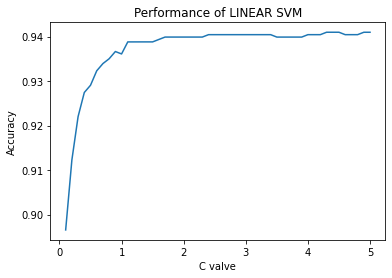

Best performing linear kernel SVM: C=4.3, Acc=0.9409635722679202


In [21]:
from sklearn import svm
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn import metrics
import heapq
import operator
import numpy as np
from mpl_toolkits.mplot3d import axes3d, Axes3D
from sklearn.svm import LinearSVC

num_fold = 10
k_fold = KFold(num_fold, True, 1)
acc = []
for coef_c in np.arange(0.1, 5.1, 0.1):
    acc_arr = np.zeros(num_fold)
    ind = 0
    for train_rows, val_rows in k_fold.split(X_train):
        model = LinearSVC(random_state=0, C=coef_c, loss='squared_hinge', dual=True)
        model.fit(X_train[train_rows], y_train[train_rows])
        pred_y = model.predict(X_train[val_rows])
        acc_arr[ind] = metrics.accuracy_score(y_train[val_rows], pred_y)
        ind += 1
    acc.append([coef_c, np.mean(acc_arr)])
plt.plot([i[0] for i in acc], [i[1] for i in acc])
plt.title("Performance of LINEAR SVM")
plt.xlabel("C valve")
plt.ylabel("Accuracy")
plt.show()
best = heapq.nlargest(1, acc, key=operator.itemgetter(1))[0]
print("Best performing linear kernel SVM: C={}, Acc={}".format(best[0], best[1]))

LSVM-ACCURACY => 85.05706134094152 %
[[1724  161]
 [ 677 3046]]


              precision    recall  f1-score   support

          -1       0.72      0.91      0.80      1885
           1       0.95      0.82      0.88      3723

    accuracy                           0.85      5608
   macro avg       0.83      0.87      0.84      5608
weighted avg       0.87      0.85      0.85      5608



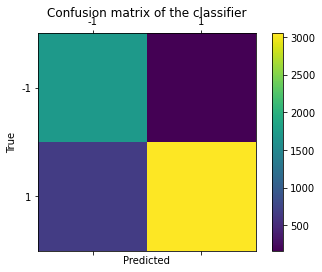

In [22]:
#model = LinearSVC(random_state=0, tol=1e-5, loss='squared_hinge',C=4.3)
model = LinearSVC(random_state=0, C=4.3, loss='squared_hinge', dual=True)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("LSVM-ACCURACY => "+str(metrics.accuracy_score(y_test, y_pred)*100)+str(" %"))

#CONFUSION MATRIX
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y_test,y_pred))
print('\n')
print(classification_report(y_test,y_pred))

#Plot confusion_matrix
labels = ['-1', '1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion_matrix(y_test,y_pred))
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

LOGISTIC-REGRESSION-ACCURACY => 82.16833095577746 %
time= 0.4779198169708252
[[1746  139]
 [ 861 2862]]


              precision    recall  f1-score   support

          -1       0.67      0.93      0.78      1885
           1       0.95      0.77      0.85      3723

    accuracy                           0.82      5608
   macro avg       0.81      0.85      0.81      5608
weighted avg       0.86      0.82      0.83      5608



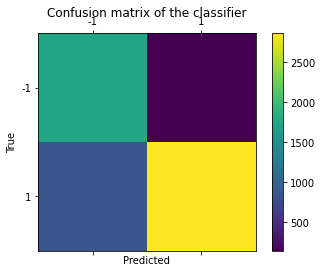

In [23]:
#logistic regression
import time
start=time.time()
from sklearn import linear_model
from sklearn import metrics
log=linear_model.LogisticRegression()


log.fit(X_train,y_train)
y_pred=(log.predict(X_test))
print("LOGISTIC-REGRESSION-ACCURACY => "+str(metrics.accuracy_score(y_test, y_pred)*100)+str(" %"))
end=time.time()
print("time=",end-start)
#CLASSIFICATION REPORT
from sklearn.metrics import classification_report,confusion_matrix
#CONFUSION MATRIX
print(confusion_matrix(y_test,y_pred))
print('\n')
print(classification_report(y_test,y_pred))

#Plot confusion_matrix
labels = ['-1', '1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion_matrix(y_test,y_pred))
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Adaboost-ACCURACY => 78.28102710413695 %
time=3.248260736465454
[[1654  231]
 [ 987 2736]]


              precision    recall  f1-score   support

          -1       0.63      0.88      0.73      1885
           1       0.92      0.73      0.82      3723

    accuracy                           0.78      5608
   macro avg       0.77      0.81      0.77      5608
weighted avg       0.82      0.78      0.79      5608



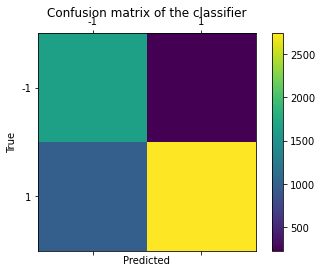

In [24]:
import time
start=time.time()
from sklearn.ensemble import AdaBoostClassifier
abc = AdaBoostClassifier()

# Train Adaboost Classifer
model = abc.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Adaboost-ACCURACY => "+str(metrics.accuracy_score(y_test, y_pred)*100)+str(" %"))
end=time.time()
print("time="+str(end-start))


#CLASSIFICATION REPORT
from sklearn.metrics import classification_report,confusion_matrix
#CONFUSION MATRIX
print(confusion_matrix(y_test,y_pred))
print('\n')
print(classification_report(y_test,y_pred))

#Plot confusion_matrix
labels = ['-1', '1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion_matrix(y_test,y_pred))
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


Confusion Matrix : model evaluation
[[1498  387]
 [1184 2539]]

 Classification report :
              precision    recall  f1-score   support

          -1       0.56      0.79      0.66      1885
           1       0.87      0.68      0.76      3723

    accuracy                           0.72      5608
   macro avg       0.71      0.74      0.71      5608
weighted avg       0.76      0.72      0.73      5608

Decision Tree-ACCURACY => 71.98644793152638 %



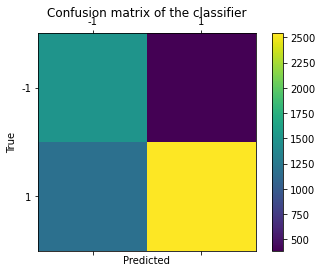

In [25]:
#DECISION TREE
import time
Start = time.time ()
from sklearn.tree import DecisionTreeClassifier 
Decision_tree= DecisionTreeClassifier(criterion = 'gini') 
Decision_tree.fit(X_train, y_train)
Y_pred = Decision_tree.predict(X_test) 
    
print("\nConfusion Matrix : model evaluation")
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, Y_pred))
    
print("\n Classification report :")
from sklearn.metrics import classification_report
print(classification_report(y_test, Y_pred))
    

from sklearn import metrics
print("Decision Tree-ACCURACY => "+str(metrics.accuracy_score(y_test, Y_pred)*100)+str(" %")+"\n")

#Plot confusion_matrix
labels = ['-1', '1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion_matrix(y_test,Y_pred))
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

RandomForest-ACCURACY => 70.66690442225392 %
time=8.050078392028809
[[1743  142]
 [1503 2220]]


              precision    recall  f1-score   support

          -1       0.54      0.92      0.68      1885
           1       0.94      0.60      0.73      3723

    accuracy                           0.71      5608
   macro avg       0.74      0.76      0.70      5608
weighted avg       0.80      0.71      0.71      5608



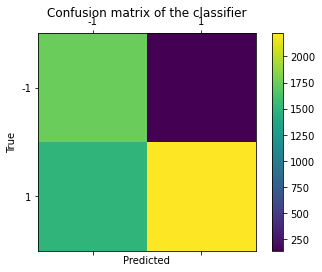

In [26]:
import pandas as pd
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
# predictions
y_pred = rfc.predict(X_test)

print("RandomForest-ACCURACY => "+str(metrics.accuracy_score(y_test, y_pred)*100)+str(" %"))
end=time.time()
print("time="+str(end-start))


#CLASSIFICATION REPORT
from sklearn.metrics import classification_report,confusion_matrix
#CONFUSION MATRIX
print(confusion_matrix(y_test,y_pred))
print('\n')
print(classification_report(y_test,y_pred))

#Plot confusion_matrix
labels = ['-1', '1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion_matrix(y_test,y_pred))
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()